# Melbourne Housing

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [95]:
def eval_preds(y_true_log, y_pred_log):
    #Valuta RMSE e MAE sulla scala reale (esponenziale del log).
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

def group_rare_categories(df, col, threshold=0.01):
    #Raggruppa le categorie rare in 'Other'.
    freq = df[col].value_counts(normalize=True)
    rare = freq[freq < threshold].index
    df[col] = df[col].replace(rare, 'Other')
    return df

In [96]:
df = pd.read_csv('Melbourne_housing.csv')

C:\Users\Rosy\AppData\Local\Temp\ipykernel_15584\1901315617.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Melbourne_housing.csv')


In [97]:
df.head()

,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom,...,Landsize,BuildingArea,YearBuilt,CouncilArea,Latitude,Longtitude,Regionname,Propertycount,ParkingArea,Price
0,Abbotsford,68 Studley St,2,h,SS,Jellis,3/9/2016,2.5,3067.0,2.0,...,126.0,inf,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0,Carport,NaN
1,Airport West,154 Halsey Rd,3,t,PI,Nelson,3/9/2016,13.5,3042.0,3.0,...,303.0,225,2016.0,Moonee Valley City Council,-37.7180,144.8780,Western Metropolitan,3464.0,Detached Garage,840000.0
2,Albert Park,105 Kerferd Rd,2,h,S,hockingstuart,3/9/2016,3.3,3206.0,2.0,...,120.0,82,1900.0,Port Phillip City Council,-37.8459,144.9555,Southern Metropolitan,3280.0,Attached Garage,1275000.0
3,Albert Park,85 Richardson St,2,h,S,Thomson,3/9/2016,3.3,3206.0,2.0,...,159.0,inf,NaN,Port Phillip City Council,-37.8450,144.9538,Southern Metropolitan,3280.0,Indoor,1455000.0
4,Alphington,30 Austin St,3,h,SN,McGrath,3/9/2016,6.4,3078.0,3.0,...,174.0,122,2003.0,Darebin City Council,-37.7818,145.0198,Northern Metropolitan,2211.0,Parkade,NaN


In [98]:
columns_to_use = ['Suburb', 'Rooms', 'Type', 'Method', 'SellerG', 'Regionname',
                  'Propertycount', 'Distance', 'CouncilArea', 'Bedroom', 'Bathroom', 
                  'Car', 'Landsize', 'BuildingArea', 'Price']
df = df[columns_to_use].copy()

## Gestione dei valori mancanti

In [99]:
# Riempimento con 0 
cols_fill_0 = ['Car', 'Bathroom', 'Bedroom', 'Distance', 'Propertycount']
df[cols_fill_0] = df[cols_fill_0].fillna(0)

for col in ['Landsize', 'BuildingArea']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(df[col].mean())

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

In [100]:
# --- RIMOZIONE OUTLIER ---
for col in ['Price', 'Landsize', 'BuildingArea']:
    q_low, q_high = df[col].quantile([0.01, 0.99])
    df = df[(df[col] >= q_low) & (df[col] <= q_high)]

# --- CATEGORIE RARE ---
for col in ['Suburb', 'SellerG', 'Regionname', 'CouncilArea']:
    df = group_rare_categories(df, col)

## Feature Engineer

In [101]:
df['Rooms_per_Landsize'] = df['Rooms'] / (df['Landsize'] + 1)
df['TotalRooms'] = df['Rooms'] + df['Bathroom'] + df['Car']
df['Bath_per_Bed'] = df['Bathroom'] / (df['Bedroom'] + 1)
df['Rooms_per_Area'] = df['TotalRooms'] / (df['Landsize'] + 1)
df['Landsize_log'] = np.log1p(df['Landsize'])
df['BuildingArea_log'] = np.log1p(df['BuildingArea'])
df['Area_per_Room'] = df['Landsize'] / (df['Rooms'] + 1)
df['BuildingRatio'] = df['BuildingArea'] / (df['Landsize'] + 1)

print(f"Righe residue: {df.shape[0]}")

Righe residue: 10144


## Feature e target

In [102]:
y = np.log1p(df['Price'])
X = df.drop('Price', axis=1)

In [103]:
categorical_cols = ['Suburb', 'Type', 'Method', 'SellerG', 'Regionname', 'CouncilArea']
numeric_cols = [col for col in X.columns if col not in categorical_cols]

In [104]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), categorical_cols)
    ],
    remainder='drop'
)

# Applicazione del Preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Generazione dei nomi di feature completi per Pandas
feature_names = numeric_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))

# Conversione in DataFrame per il training uniforme
X_train_scaled = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)

print(f"Shape X_train (scaled): {X_train_scaled.shape}")

Shape X_train (scaled): (8115, 94)


## Modelli lineari (Ridge, Lasso, ElasticNet)

In [105]:
# LassoCV (L1) con CV e alpha ottimizzato
lasso_model = LassoCV(alphas=np.logspace(-3,2,20), cv=5, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)

y_pred_lasso = lasso_model.predict(X_test_scaled)

In [106]:
# RidgeCV (L2) con CV
ridge_model = RidgeCV(alphas=np.logspace(-2,2,20), cv=5)
ridge_model.fit(X_train_scaled, y_train)

y_pred_ridge = ridge_model.predict(X_test_scaled)

In [107]:
elastic = ElasticNetCV(
    l1_ratio=np.linspace(0.1,0.9,9),
    alphas=np.logspace(-3,2,20),
    cv=5,
    max_iter=10000,
    random_state=42
)
elastic.fit(X_train_scaled, y_train)
y_pred_elastic = elastic.predict(X_test_scaled)

## Ottimizzazione Hyper-Parametri con Grid Search

In [115]:
cv_gs = KFold(n_splits=3, shuffle=True, random_state=42) # Usiamo 3 fold per velocizzare la Grid Search

# RandomForest
print("\n--- IRandomForestRegressor ---")
param_grid_rf = {'n_estimators':[100,200], 
                 'max_depth':[10,20], 
                 'min_samples_split':[5,10]}

rf_gs = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1),
                     param_grid_rf, scoring='neg_mean_squared_error', cv=cv_gs, n_jobs=-1, verbose=1)

rf_gs.fit(X_train_scaled, y_train)
best_rf = rf_gs.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)

# XGBoost
print("\n--- XGBRegressor ---")
param_grid_xgb = {'n_estimators':[100,200], 
                  'max_depth':[4,6], 
                  'learning_rate':[0.05,0.1]}

xgb_gs = GridSearchCV(XGBRegressor(random_state=42, verbosity=0, objective='reg:squarederror'),
                      param_grid_xgb, scoring='neg_mean_squared_error', cv=cv_gs, n_jobs=-1, verbose=1)
xgb_gs.fit(X_train_scaled, y_train)
best_xgb = xgb_gs.best_estimator_
y_pred_xgb = best_xgb.predict(X_test_scaled)




--- IRandomForestRegressor ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits

--- XGBRegressor ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [110]:
# --- RACCOLTA MODELLI E PREDIZIONI ---
models = {
    "Ridge": (ridge_model, y_pred_ridge),
    "Lasso": (lasso_model, y_pred_lasso),
    "ElasticNet": (elastic_model, y_pred_elastic),
    "RandomForest": (best_rf, y_pred_rf),
    "XGBoost": (best_xgb, y_pred_xgb)
}

## Valutazione

In [111]:
results = []
predictions = {}

for name, (model, y_pred) in models.items():
    r2 = r2_score(y_test, y_pred)
    rmse, mae = eval_preds(y_test, y_pred)
    results.append({"Modello": name, "R2 (Log)": r2, "RMSE ($)": rmse, "MAE ($)": mae})
    predictions[name] = y_pred

results_df = pd.DataFrame(results).sort_values(by="R2 (Log)", ascending=False)

print("\n=== RISULTATI FINALI (Modelli addestrati su dati SCALATI) ===")
print(results_df.to_string(index=False))


=== RISULTATI FINALI (Modelli addestrati su dati SCALATI) ===
     Modello  R2 (Log)      RMSE ($)       MAE ($)
     XGBoost  0.885077 236983.884013 149083.936052
RandomForest  0.868374 251438.584574 159017.561582
       Ridge  0.820175 282632.086028 182488.112650
  ElasticNet  0.819132 284811.535214 183189.759755
       Lasso  0.810055 292379.003053 188365.638187


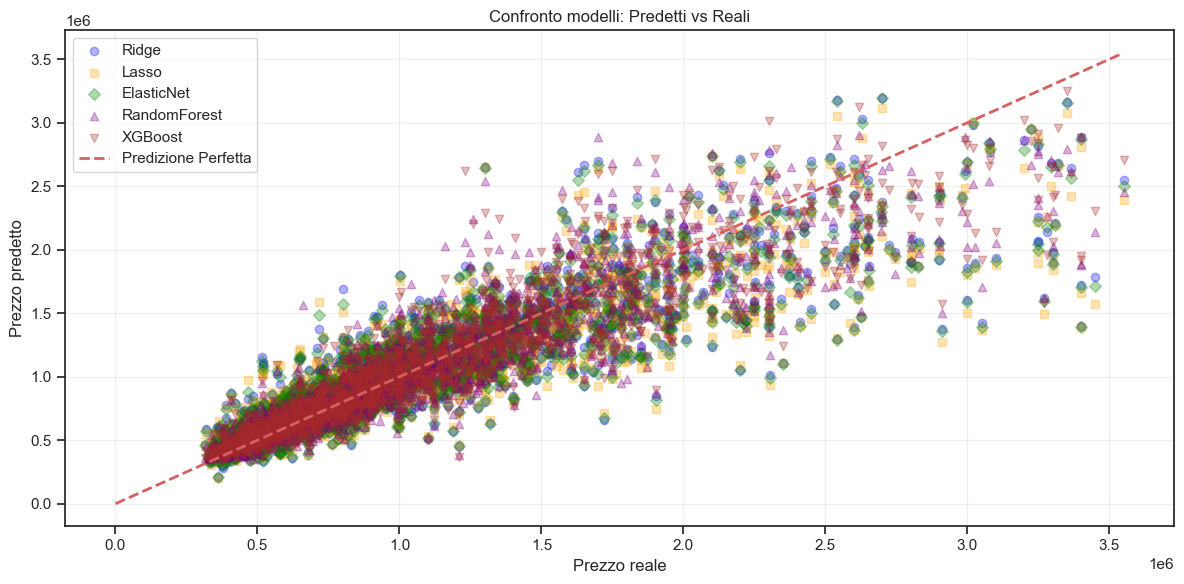

In [113]:
# grafico comparativo 
plt.figure(figsize=(12,6))
y_test_real = np.expm1(y_test)
colors = ["blue", "orange", "green", "purple", "brown"]
markers = ["o", "s", "D", "^", "v"]

for i, (name, y_pred) in enumerate(predictions.items()):
    plt.scatter(y_test_real, np.expm1(y_pred), alpha=0.3, label=name, color=colors[i], marker=markers[i])


plt.plot([0, max(y_test_real)], [0, max(y_test_real)], "r--", lw=2, label="Predizione Perfetta")
plt.xlabel("Prezzo reale")
plt.ylabel("Prezzo predetto")
plt.title("Confronto modelli: Predetti vs Reali")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()